ML Final
====                            
106061121 莊裕嵐 106061140 許暐彤
* 這個project中，我們希望能藉由input當地（如：日本東京）各項天氣資料（如：平均溫度、平均降水量、日照時間，及平均濕度等），來判定該年櫻花開花時間與時長。
* 我們假設開花時機與短期天氣資訊有關，而花期時長則與長期天氣資訊相關，並由此分成2個model來訓練。

## Implementation 1：開花時機
* 先手動將日本各地、各年天氣相關數據從日本氣象廳網站（http://www.data.jma.go.jp/obd/stats/etrn/index.php ）上下載下來，再做初步的data preprocessing，如：刪除無關資料、填補空缺（用平均值、0等填補）等。手動將櫻花開花日（https://www.data.jma.go.jp/sakura/data/sakura003_06.html ）與滿開日（https://www.data.jma.go.jp/sakura/data/sakura004_06.html ）當作label填至dataset中，並假設滿開的後半旬會是櫻吹雪（即花期結束）。
* 考慮到時間間隔的密度與資料擷取的效率，我們選用時間間隔較短的半旬（約5天）天氣資料做訓練。分別做出能辨別當半旬是開花、開花中、滿開、謝花、還是非花期的classifier，以及能預測下半旬是否開花的model。
* 我們選取全年的資料作為input，花期的時間佔整年的一小部分、相對短暫，也造成data分布不均勻。經實驗後發現resample、平衡classes間的差距後，達成的performance比較好。
* 將data標準化後，用LDA降低維度。每次取最高可留下features數作為LDA的參數，辨別當半旬是開花、開花中、滿開、謝花、還是非花期的classifier用4，預測下半旬是否開花的model則用1。
* 在模型的選擇上，辨別當半旬是開花、開花中、滿開、謝花、還是非花期的classifier使用SVM。用balance後的dataset訓練，正確率可以達到99.9%。預測下半旬是否開花的model則分別使用SVM、Ensemble Classifier，及Random Forest，最後發現SVM效率最好。兩個models都有用grid search找最佳參數。
* 另外，預測開花時，希望model不要錯過任何可能開花的機會、要盡可能地猜中，判定performance上使用f1。最後達成的正確率約為99.5%。
* 最後用pipeline簡化我們的程式。

## Result
以下參數由Discussion裡探討得出。

### 1-1 & 1-2 : 辨別當半旬是開花、開花中、滿開、謝花、還是非花期的classifier

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

# read in data for classification
path = "data_tokyo.csv"
df = pd.read_csv(path, encoding='latin1')

# put in data & turn y into num
data = df.T
X = []
y = []
for i in range(len(data.T)): # for all input data
    # store all data into X & y
    X.append(np.array(data[i][3:24]))
    y.append(data[i][24])

# balance data
y = np.array(y)
X = np.array(X)
X_upsampled, y_upsampled = resample(X[y==1],
                                   y[y==1],
                                   replace=True,
                                   n_samples=X[y==0].shape[0],
                                   random_state=123)
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))

X_upsampled, y_upsampled = resample(X[y==2],
                                   y[y==2],
                                   replace=True,
                                   n_samples=X[y==0].shape[0],
                                   random_state=123)
X_bal = np.vstack((X_bal, X_upsampled))
y_bal = np.hstack((y_bal, y_upsampled))

X_upsampled, y_upsampled = resample(X[y==3],
                                   y[y==3],
                                   replace=True,
                                   n_samples=X[y==0].shape[0],
                                   random_state=123)
X_bal = np.vstack((X_bal, X_upsampled))
y_bal = np.hstack((y_bal, y_upsampled))

X_upsampled, y_upsampled = resample(X[y==4],
                                   y[y==4],
                                   replace=True,
                                   n_samples=X[y==0].shape[0],
                                   random_state=123)
X_bal = np.vstack((X_bal, X_upsampled))
y_bal = np.hstack((y_bal, y_upsampled))

# split into 70% training & 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_bal, 
        y_bal, test_size=0.3, random_state=1, stratify=y_bal)

# standardize Xs & feature-extract Xs & train SVM model w/ best parameters
# 'C': 0.1, 'gamma': 10.0, 'kernel': 'rbf'
pipe_svm = make_pipeline(StandardScaler(),
                         LDA(n_components=4),
                         SVC(C=0.1, gamma=10.0, kernel='rbf', random_state=1))
pipe_svm.fit(X_train, y_train)
print('Test accuracy: % .3f' % pipe_svm.score(X_test, y_test))

Test accuracy:  0.999


### 1-3 & 1-4 & 1-5: 預測下半旬是否開花的model

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

# read in data for prediction
path = "data_tokyo_pre.csv"
df = pd.read_csv(path, encoding='latin1')

# put data into X & y
data = df.T
X = []
y = []
for i in range(len(data.T)): # for all input data
    # store all data into X & y
    X.append(np.array(data[i][3:24]))
    y.append(data[i][24])

# balance data
y = np.array(y)
X = np.array(X)
X_upsampled, y_upsampled = resample(X[y==1],
                                   y[y==1],
                                   replace=True,
                                   n_samples=X[y==0].shape[0],
                                   random_state=123)
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))

# split into 70% training & 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_bal, 
        y_bal, test_size=0.3, random_state=1, stratify=y_bal)

# standardize Xs & feature-extract Xs & train SVM model w/ best parameters
# 'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'
pipe_svm = make_pipeline(StandardScaler(),
                         LDA(n_components=1),
                         SVC(C=1000.0, gamma=1000.0, kernel='rbf', random_state=1))
pipe_svm.fit(X_train, y_train)
print('Test accuracy: % .3f' % pipe_svm.score(X_test, y_test))

Test accuracy:  0.995


### Discussion

利用Google Chrome擴充功能－－Table Capture，我們可以將日本各地、各年天氣相關數據從日本氣象廳網站（http://www.data.jma.go.jp/obd/stats/etrn/index.php ）上下載下來。再做初步的data preprocessing，如：刪除無關資料（如：海上氣壓、風向）、用平均值填補空缺等。其中，原資料中的"--"表示完全沒有，0表示不足1，0.0則是表示不足0.1。為了方便處理，上述3種表示方法皆用0取代。

Label部分則是手動輸入櫻花開花日（https://www.data.jma.go.jp/sakura/data/sakura003_06.html ）與滿開日（https://www.data.jma.go.jp/sakura/data/sakura004_06.html ），並假設滿開的後半旬會是櫻吹雪（即花期結束）。

#### 1-1：用unbalanced dataset辨別當半旬是開花、開花中、滿開、謝花、還是非花期的classifier

In [3]:
import pandas as pd
path = "data_tokyo.csv"
df = pd.read_csv(path, encoding='latin1')
df.head()

,year,month,day,atm(hPa),Rav(mm),Rmax_day(mm),Rmax_hr(mm),Rmax_10min(mm),Tav(¢J),Tav_max(¢J),...,sun (h),sunshine (MJ/¢T),snow(cm),snow_max(cm),snow_depth(cm),cloud,snow_day,fog_day,thunder_day,Label
0,2008,1,1 to 5,1009.2,0.0,0.0,0.0,0.0,6.2,10.7,...,37.8,10.4,0,0,0,1.6,0,0,0,0
1,2008,1,6 to 10,1011.4,0.0,0.0,0.0,0.0,9.0,12.9,...,30.0,8.4,0,0,0,3.8,0,0,0,0
2,2008,1,11 to 15,1015.4,6.0,6.0,2.0,0.5,6.1,9.1,...,15.5,6.0,0,0,0,7.4,0,0,0,0
3,2008,1,16 to 20,1020.2,0.0,0.0,0.0,0.0,4.6,8.0,...,26.5,9.3,0,0,0,8.0,2,0,0,0
4,2008,1,21 to 25,1012.9,10.5,10.5,2.0,0.5,4.1,6.9,...,22.1,7.9,0,0,0,6.7,1,0,0,0


雖然讀取進來的input有亂數（主要在header的單位表示上），不過不影響我們features的部分。讀取日期與label以外的資料放入X，並把label放入y。

In [4]:
import numpy as np

data = df.T

X = []
y = []
for i in range(len(data.T)):          # read total input data
    # store all data into X & y
    X.append(np.array(data[i][3:24])) # skip dates
    y.append(data[i][24])             # label
print("X:", X[2])
print("Label:", y[2])

X: [1015.4 6.0 6.0 2.0 0.5 6.1 9.1 3.3 13.0 1.9 45 23 15.5 6.0 0 0 0 7.4 0 0
 0]
Label: 0


把所有data讀進來後，可以利用train_test_split分成training與testing data。應該要有936組samples，各21個features。

In [5]:
from sklearn.model_selection import train_test_split
# split into 70% training & 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, 
        y, test_size=0.3, random_state=1, stratify=y)
print("X_train shape:", np.array(X_train).shape, "y_train shape:", np.array(y_train).shape)
print("X_test shape:", np.array(X_test).shape, "y_test shape:", np.array(y_test).shape)

X_train shape: (655, 21) y_train shape: (655,)
X_test shape: (281, 21) y_test shape: (281,)


有了training與testing data，我們可以standardize它們。要注意testing data不能fit到。

In [6]:
from sklearn.preprocessing import StandardScaler

# standardize Xs
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

在降低features維度、降低系統計算量上，我選擇使用feature extraction的LDA。因為總共有5個classes（開花、開花中、滿開、謝花，以及非花期），使用LDA時最後留下最多只有4個components。我選擇盡可能留下features，因此給它4作為參數。降維度時要注意，X_test不能fit到。

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=4)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)
print(X_train_lda.shape)
print(X_test_lda.shape)
lda.scalings_

(655, 4)
(281, 4)


array([[  0.12296719,   0.54125559,   0.15654731,   0.17750079],
       [  0.54903313,   0.3137964 ,   0.31461766,   0.77591575],
       [ -0.54030289,  -0.30826651,  -0.0462416 ,  -0.44857304],
       [ -0.15668896,  -0.15003383,  -0.41663565,   0.51968292],
       [  0.12206149,   0.35018218,   0.17608409,  -0.49511936],
       [ -1.68942147, -11.38878524,   4.61696636, -11.01410342],
       [ -1.55955899,   3.42817038,  -6.68941339,   5.16068574],
       [  1.97474609,   7.28684348,  -1.67693406,   5.04956667],
       [  2.36297383,  -1.06590885,   1.56030091,   0.76898327],
       [ -1.94252937,   1.58325895,   2.16906202,   0.3473863 ],
       [ -0.09266294,  -0.53786174,   1.32069104,   0.30820939],
       [ -0.23253636,   0.1980671 ,  -1.0469985 ,   0.11423336],
       [ -0.58696868,   0.06294866,   1.2137452 ,  -1.79470082],
       [  1.16545231,   0.73936161,  -0.28307378,   1.04990111],
       [  0.66836615,  -2.16722232,  -0.07760983,  -0.69109764],
       [ -0.47362189,   2

有了降過維度的input features，我們可以著手開始建辨識的model。我選擇使用SVM作為這次模型的基礎，並利用Grid Search，找到表現最佳的參數組合。Performance的判定上使用accuracy，並利用1/4的validation fold訓練出更好的model（因為其中一個class數量較少，無法使用0.1作為validation fold）。另外，為了有效地利用CPU，將n_jobs設為-1。

要注意餵training X與testing X時，都要給降過維度的，即X_train_lda與X_test_lda。

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from datetime import datetime

# train SVM using Grid Search
svm = SVC(random_state=1)
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'C': param_range,
               'kernel':['linear']},
              {'C': param_range,
               'gamma': param_range,
               'kernel': ['rbf']}]
gs = GridSearchCV(estimator=svm,
                 param_grid = param_grid,
                 scoring='accuracy',
                 refit=True,
                 cv=4,
                 n_jobs=-1)
start=datetime.now()
gs = gs.fit(X_train_lda, y_train)
print('Training time:', datetime.now()-start)
print(gs.best_score_)
print(gs.best_params_)

Training time: 0:01:53.287061
0.952678437827323
{'C': 0.0001, 'kernel': 'linear'}


因為上面的refit設定為true，function會幫我們train好model。藉由以下程式碼可以得到tesing data的正確率，要注意X_test要給標準化，且經過feature extraction過的，即X_test_lda。

In [9]:
clf = gs.best_estimator_
print('Test accuracy: % .3f' % clf.score(X_test_lda, y_test))

Test accuracy:  0.950


可以看出使用SVM的正確率相當高。但因為大部分時候為沒開花的狀況，難以確保model不是全猜"非花期"，才達到如此高的正確率。

#### 1-2：用balanced dataset辨別當半旬是開花、開花中、滿開、謝花、還是非花期的classifier
基於上述問題，嘗試balance input samples，並使用accuracy以外的F1-score來判定performance。

先印出各個class的數量，以了解data的分布。我們可以直接重複使用上面的X, y參數。

In [10]:
print('Labels counts in y', np.bincount(y))

Labels counts in y [891  13   6  13  13]


可以看到整個花期與非花期的比例相差甚大，又因為最少數量的6筆資料稱不上"大"，我決定upsample數量較少的class，最後得到5組各891個samples的data set。

In [11]:
from sklearn.utils import resample
y = np.array(y)
X = np.array(X)

X_upsampled, y_upsampled = resample(X[y==1],
                                   y[y==1],
                                   replace=True,
                                   n_samples=X[y==0].shape[0],
                                   random_state=123)
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))
print('Labels counts in y_bal', np.bincount(y_bal))

X_upsampled, y_upsampled = resample(X[y==2],
                                   y[y==2],
                                   replace=True,
                                   n_samples=X[y==0].shape[0],
                                   random_state=123)
X_bal = np.vstack((X_bal, X_upsampled))
y_bal = np.hstack((y_bal, y_upsampled))
print('Labels counts in y_bal', np.bincount(y_bal))

X_upsampled, y_upsampled = resample(X[y==3],
                                   y[y==3],
                                   replace=True,
                                   n_samples=X[y==0].shape[0],
                                   random_state=123)
X_bal = np.vstack((X_bal, X_upsampled))
y_bal = np.hstack((y_bal, y_upsampled))
print('Labels counts in y_bal', np.bincount(y_bal))

X_upsampled, y_upsampled = resample(X[y==4],
                                   y[y==4],
                                   replace=True,
                                   n_samples=X[y==0].shape[0],
                                   random_state=123)
X_bal = np.vstack((X_bal, X_upsampled))
y_bal = np.hstack((y_bal, y_upsampled))
print('Labels counts in y_bal', np.bincount(y_bal))

Labels counts in y_bal [891 891]
Labels counts in y_bal [891 891 891]
Labels counts in y_bal [891 891 891 891]
Labels counts in y_bal [891 891 891 891 891]


接著重複1-1的步驟，分成training與testing set、做standardization，並用LDA降低input features維度。

In [12]:
# split into 70% training & 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_bal, 
        y_bal, test_size=0.3, random_state=1, stratify=y_bal)
print("X_train shape:", np.array(X_train).shape, "y_train shape:", np.array(y_train).shape)
print("X_test shape:", np.array(X_test).shape, "y_test shape:", np.array(y_test).shape)

# standardize Xs
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

lda = LDA(n_components=4)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)
print(X_train_lda.shape)
print(X_test_lda.shape)
lda.scalings_

X_train shape: (3118, 21) y_train shape: (3118,)
X_test shape: (1337, 21) y_test shape: (1337,)
(3118, 4)
(1337, 4)


array([[-0.02542139, -0.06898238, -0.19378434, -0.37750223],
       [ 0.31647064, -0.34648617, -0.59609098,  0.32950184],
       [-0.39683662,  0.34369301,  0.04200649, -0.51567967],
       [-0.21174496,  0.32177308,  0.01803565,  0.93036271],
       [ 0.21691474, -0.67009378,  0.15310779, -0.6953184 ],
       [ 1.63578526,  5.29066516, -2.84906556, -1.48110681],
       [-1.63201377, -0.69535893,  1.4559581 ,  1.76325764],
       [-0.43095728, -4.33053157,  1.07357468,  2.66722099],
       [ 0.43836529,  0.41995835,  0.58345177, -0.97779521],
       [-1.33391132, -0.25891746, -0.11637478, -2.43659859],
       [ 0.30986901, -0.14719654, -1.21518331, -0.93828615],
       [-0.61685507, -0.53041519,  0.26342029,  0.91590111],
       [-0.5836573 ,  0.81031838,  0.66629079,  0.46374783],
       [ 1.51224886, -0.89183769, -1.32556393, -0.60018614],
       [-0.6362824 ,  2.13825882, -0.03404653,  1.26177055],
       [ 0.79089082, -1.96855827, -0.14277732, -1.12099397],
       [-0.26615093, -0.

同1-1，我們繼續使用SVM作為這次模型的基礎，利用Grid Search，找到表現最佳的參數組合。Performance的判定上使用能計算所有true positives, false negatives及false positives數的f1_micro，並利用0.1的validation fold訓練出更好的model。另外，為了有效地利用CPU，將n_jobs設為-1。

In [13]:
from sklearn.metrics import f1_score

# train SVM using Grid Search
svm = SVC(random_state=1)
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'C': param_range,
               'kernel':['linear']},
              {'C': param_range,
               'gamma': param_range,
               'kernel': ['rbf']}]
gs = GridSearchCV(estimator=svm,
                 param_grid = param_grid,
                 scoring='f1_micro',
                 refit=True,
                 cv=10,
                 n_jobs=-1)
start=datetime.now()
gs = gs.fit(X_train_lda, y_train)
print('Training time:', datetime.now()-start)
print(gs.best_score_)
print(gs.best_params_)

Training time: 0:05:07.737406
1.0
{'C': 0.1, 'gamma': 10.0, 'kernel': 'rbf'}


In [14]:
from sklearn import metrics
clf = gs.best_estimator_

y_pred = clf.predict(X_test_lda)
print ("accuracy:",metrics.accuracy_score(y_test, y_pred))
print ("f1 score macro:",metrics.f1_score(y_test, y_pred, average='macro') )
print ("f1 score micro:",metrics.f1_score(y_test, y_pred, average='micro') )

accuracy: 0.9992520568436799
f1 score macro: 0.9992523364485981
f1 score micro: 0.9992520568436799


雖然training time約為原本的2.5倍左右，balance後train出來的模型正確率更高了。不過這個模型並不能"預測"櫻花開花，需要給當"半旬"（約5天）的天氣資料，它才能給出"當半旬"是否開花。

#### 1-3：用SVM預測下半旬是否開花
改變原本dataset內容，假設櫻花開花只與前半旬天氣有關、且僅考慮開花時間點，不考慮什麼時候滿開，以此進行預測。如此一來，只要input當半旬天氣資料，便能"預測"下半旬是否開花。

新的dataset僅更改原本label，開花前半旬為1，其他為0。用與前兩部分相同方式讀取資料。

In [15]:
import pandas as pd
path = "data_tokyo_pre.csv"

df = pd.read_csv(path, encoding='latin1')
df.head()

,year,month,day,atm(hPa),Rav(mm),Rmax_day(mm),Rmax_hr(mm),Rmax_10min(mm),Tav(¢J),Tav_max(¢J),...,sun (h),sunshine (MJ/¢T),snow(cm),snow_max(cm),snow_depth(cm),cloud,snow_day,fog_day,thunder_day,Label
0,2008,1,1 to 5,1009.2,0.0,0.0,0.0,0.0,6.2,10.7,...,37.8,10.4,0,0,0,1.6,0,0,0,0
1,2008,1,6 to 10,1011.4,0.0,0.0,0.0,0.0,9.0,12.9,...,30.0,8.4,0,0,0,3.8,0,0,0,0
2,2008,1,11 to 15,1015.4,6.0,6.0,2.0,0.5,6.1,9.1,...,15.5,6.0,0,0,0,7.4,0,0,0,0
3,2008,1,16 to 20,1020.2,0.0,0.0,0.0,0.0,4.6,8.0,...,26.5,9.3,0,0,0,8.0,2,0,0,0
4,2008,1,21 to 25,1012.9,10.5,10.5,2.0,0.5,4.1,6.9,...,22.1,7.9,0,0,0,6.7,1,0,0,0


把讀取進來的資料分別放進X, y。

In [16]:
import numpy as np

data = df.T

X = []
y = []
for i in range(len(data.T)): # for all input data
    # store all data into X & y
    X.append(np.array(data[i][3:24]))
    y.append(data[i][24])
print("X:", X[2])
print("Label:", y[2])
print('Labels counts in y', np.bincount(y))

X: [1015.4 6.0 6.0 2.0 0.5 6.1 9.1 3.3 13.0 1.9 45 23 15.5 6.0 0 0 0 7.4 0 0
 0]
Label: 0
Labels counts in y [923  13]


可以看到label=1的數量相對稀少很多，而這也是合理的，因為櫻花一年只會開一次。為了train出更好的model，我們先upsample、平衡兩個classes間的差距。

In [17]:
from sklearn.utils import resample
y = np.array(y)
X = np.array(X)

X_upsampled, y_upsampled = resample(X[y==1],
                                   y[y==1],
                                   replace=True,
                                   n_samples=X[y==0].shape[0],
                                   random_state=123)
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))
print('Labels counts in y_bal', np.bincount(y_bal))

Labels counts in y_bal [923 923]


同樣將balanced dataset分成training與testing set、做standardization，並用LDA降低input features維度。因為總共只有2種classes，LDA最多只能留下1個feature。

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# split into 70% training & 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_bal, 
        y_bal, test_size=0.3, random_state=1, stratify=y_bal)
print("X_train shape:", np.array(X_train).shape, "y_train shape:", np.array(y_train).shape)
print("X_test shape:", np.array(X_test).shape, "y_test shape:", np.array(y_test).shape)

# standardize Xs
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)
print(X_train_lda.shape)
print(X_test_lda.shape)
lda.scalings_

X_train shape: (1292, 21) y_train shape: (1292,)
X_test shape: (554, 21) y_test shape: (554,)
(1292, 1)
(554, 1)


array([[-2.31414079e-02],
       [ 1.25319653e-01],
       [-2.16563968e-01],
       [ 1.70098773e-01],
       [-1.93857443e-01],
       [ 2.60421348e+00],
       [-1.93333859e+00],
       [-2.83079594e+00],
       [ 1.12271026e+00],
       [-5.00371809e-01],
       [ 2.66694394e-01],
       [ 8.15765736e-03],
       [-9.64220152e-01],
       [ 1.23778639e+00],
       [ 3.79199332e-01],
       [-2.99238714e-03],
       [-3.40257071e-01],
       [ 1.43701291e-02],
       [-5.08542075e-01],
       [ 1.38291015e-03],
       [-7.80961031e-02]])

繼續使用SVM，並利用Grid Search找到表現最佳的參數組合。希望要盡可能地答對"開花時間"，Performance的判定上使用f1，並利用0.1的validation fold訓練出更好的model。另外，為了有效地利用CPU，將n_jobs設為-1。

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from sklearn.metrics import f1_score

# train SVM using Grid Search
svm = SVC(random_state=1)
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'C': param_range,
               'kernel':['linear']},
              {'C': param_range,
               'gamma': param_range,
               'kernel': ['rbf']}]
gs = GridSearchCV(estimator=svm,
                 param_grid = param_grid,
                 scoring='f1',
                 refit=True,
                 cv=10,
                 n_jobs=-1)
start=datetime.now()
gs = gs.fit(X_train_lda, y_train)
print('Training time:', datetime.now()-start)
print(gs.best_score_)
print(gs.best_params_)

Training time: 0:00:24.743289
0.9900870161758537
{'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}


因為features維度下降，再加上總sample數也相對少，與1-2相比training time大幅下降。雖然performance不如1-2，但這個model才能真正地"預測"開花。

In [20]:
from sklearn import metrics
clf = gs.best_estimator_

y_pred = clf.predict(X_test_lda)
print ("accuracy:",metrics.accuracy_score(y_test, y_pred))
print ("f1 score:",metrics.f1_score(y_test, y_pred) )
print ("f1 score macro:",metrics.f1_score(y_test, y_pred, average='macro') )
print ("f1 score micro:",metrics.f1_score(y_test, y_pred, average='micro') )

accuracy: 0.9945848375451264
f1 score: 0.9946140035906643
f1 score macro: 0.9945846787463304
f1 score micro: 0.9945848375451264


可以看到不管用哪一種方式判定performance，大約都有99.5%的正確率。

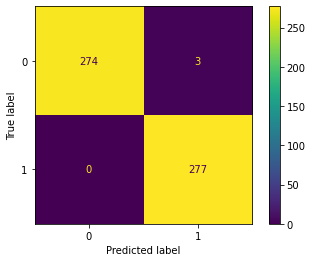

In [21]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test_lda, y_test)

從confusion matrix可以看出來，雖然這個model會有誤判的時候，但卻不會錯過任何"下半旬"開花的可能性，且預測會開花、而真的有開花的機率挺高的，約為98.9%（=277/(277+3)）。

#### 1-4：用其他classifier預測下半旬是否開花
用上述相同dataset，嘗試使用其他ML models，並比較各自的performance。

In [22]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# train model
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=10, random_state=1)
clf3 = KNeighborsClassifier()
clf4 = SVC(probability=True)

# larger weight for classifier w/ higher accuracy
eclf = VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2), ('knn', clf3), ('svm', clf4)],
     voting='soft', weights=[1,4,4,1])

# print out each & overall accuracies
for clf, label in zip([clf1, clf2, clf3, clf4, eclf], ['Logistic Regression', 'Random Forest', 'K-Neighbors', 'SVM', 'Ensemble']):
     scores = cross_val_score(clf, X_train_lda, y_train, scoring='f1', cv=5)
     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

# Predict on test set
eclf = eclf.fit(X_train_lda, y_train)
print('Test accuracy: % .3f' % eclf.score(X_test_lda, y_test))

Accuracy: 0.87 (+/- 0.02) [Logistic Regression]
Accuracy: 0.99 (+/- 0.01) [Random Forest]
Accuracy: 0.97 (+/- 0.01) [K-Neighbors]
Accuracy: 0.85 (+/- 0.03) [SVM]
Accuracy: 0.98 (+/- 0.01) [Ensemble]
Test accuracy:  0.984


可以看到當所有classifier表現都不錯時，Ensemble Classifier並沒辦法提升太多performance。我們把training accuracy最高的Random Forest單獨拉出來測試。

In [23]:
forest = RandomForestClassifier(n_estimators=10, random_state=1)
forest = forest.fit(X_train_lda, y_train)
print('Test accuracy:' , forest.score(X_test_lda, y_test))

Test accuracy: 0.9945848375451264


#### 1-5：探討Random Forest參數
因為上述Random Forest表現與SVM差不多好，又符合我們想要"預測"花期的功能，看看是否能改用Random Forest model提升它的準確率，或降低訓練時間。

Random Forest有許多參數可以調整。我將criterion設為gini，將n_jobs設為-1、盡可能地利用CPU。而為了避免overfitting，我設最大深度為1，也就是features的總數。bootstrap則是設定採樣是否有放回，我採用的方法是bagging也就是採樣會放回的方法。

n_estimators設定的是樹的總量。在其他參數固定的狀況下，我試了幾種不同值，以正確率100%為目標，選擇樹最少、表現最穩定的值以達到較佳的效率（避免過多計算）。Training與testing data直接使用上方的X_train_lda, y_train, X_test_lda, 及y_test。

Accuracy when n =  1 : 0.8700361010830325
Accuracy when n =  2 : 0.8700361010830325
Accuracy when n =  3 : 0.8700361010830325
Accuracy when n =  4 : 0.8700361010830325
Accuracy when n =  5 : 0.8700361010830325
Accuracy when n =  6 : 0.8700361010830325
Accuracy when n =  7 : 0.8700361010830325
Accuracy when n =  8 : 0.8700361010830325
Accuracy when n =  9 : 0.8700361010830325
Accuracy when n =  10 : 0.8700361010830325
Accuracy when n =  11 : 0.8700361010830325
Accuracy when n =  12 : 0.8700361010830325
Accuracy when n =  13 : 0.8700361010830325
Accuracy when n =  14 : 0.8700361010830325
Accuracy when n =  15 : 0.8700361010830325
Accuracy when n =  16 : 0.8700361010830325
Accuracy when n =  17 : 0.8700361010830325
Accuracy when n =  18 : 0.8700361010830325
Accuracy when n =  19 : 0.8700361010830325
Accuracy when n =  20 : 0.8700361010830325
Accuracy when n =  21 : 0.8700361010830325
Accuracy when n =  22 : 0.8700361010830325
Accuracy when n =  23 : 0.8700361010830325
Accuracy when n =  2

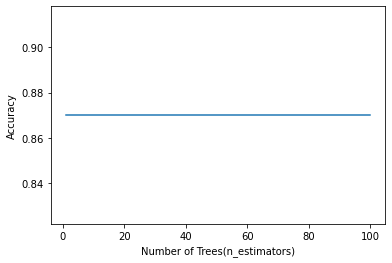

In [24]:
import matplotlib.pyplot as plt

x_axis = []                            # records number of trees
y_axis = []                            # records accuracy
acc = 0                                # stores accuracy
for i in range(1, 101):                # 1~100 trees
    # build model
    forest = RandomForestClassifier(criterion='gini', max_depth=1, n_estimators=i,
                                    bootstrap=True, random_state=1, n_jobs=-1)                   
    forest.fit(X_train_lda, y_train)
    
    x_axis.append(i)                          # put i into the list
    acc = forest.score(X_test_lda, y_test)    # get accuracy
    print('Accuracy when n = ', i, ':', acc)  # print accuracy & its num of trees
    y_axis.append(acc)                        # put acc into the list

# plot accuracy vs num of trees
plt.plot(x_axis, y_axis)
plt.xlabel('Number of Trees(n_estimators)')
plt.ylabel('Accuracy')
plt.show()

發現將最大深度設為1後，它的performance反而沒有原本好。原本的model可能產生overfitting了。
#### 1-6：比較training time

In [25]:
# compare training time
svm = SVC(C=1000.0, gamma=1000.0, kernel='rbf', random_state=1)
start=datetime.now()                                 
svm.fit(X_train_lda, y_train)
print('Training time for SVM:', datetime.now()-start)
print('Accuracy for SVM:', svm.score(X_test_lda, y_test))

forest = RandomForestClassifier(criterion='gini', max_depth=1, n_estimators=2,
                                    bootstrap=True, random_state=1, n_jobs=-1)
start=datetime.now()                                 
forest.fit(X_train_lda, y_train)
print('Training time for Random Forest:', datetime.now()-start)
print('Accuracy for Random Forest:', forest.score(X_test_lda, y_test))

# ensemble
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=10, random_state=1)
clf3 = KNeighborsClassifier()
clf4 = SVC(probability=True)
# larger weights for classifier w/ higher accuracy
eclf = VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2), ('knn', clf3), ('svm', clf4)],
     voting='soft', weights=[1,4,4,1])
start=datetime.now() 
eclf = eclf.fit(X_train_lda, y_train)
print('Training time for Ensemble:', datetime.now()-start)
print('Accuracy for Ensemble:', eclf.score(X_test_lda, y_test))

Training time for SVM: 0:00:00.012963
Accuracy for SVM: 0.9945848375451264
Training time for Random Forest: 0:00:00.018949
Accuracy for Random Forest: 0.8700361010830325
Training time for Ensemble: 0:00:00.154587
Accuracy for Ensemble: 0.983754512635379


因為SVM的訓練時間較短，又有好的performance，我們最終選擇使用SVM為我們的model。

### 附錄：其他地區模型
用1-3的方法訓練預測其他地區櫻花花期的模型。
#### 京都
讀進input data，並進行一連串data preprocessing。因為京都完全沒有全天日照量的資料，和東京相比、它原本的features數少1。

In [26]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# read in data for prediction for Kyoto
path = "data_kyoto_pre.csv"
df = pd.read_csv(path, encoding='latin1')

# put data into X & y
data = df.T
X = []
y = []
for i in range(len(data.T)): # for total input data
    # store all data into X & y
    X.append(np.array(data[i][3:23]))
    y.append(data[i][23])

# balance data
y = np.array(y)
X = np.array(X)
X_upsampled, y_upsampled = resample(X[y==1],
                                   y[y==1],
                                   replace=True,
                                   n_samples=X[y==0].shape[0],
                                   random_state=123)
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))

# split into 70% training & 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_bal, 
        y_bal, test_size=0.3, random_state=1, stratify=y_bal)

# standardize Xs
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# feature-extract Xs
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)
print(X_train_lda.shape)
print(X_test_lda.shape)
lda.scalings_

(1292, 1)
(554, 1)


array([[ 0.35318174],
       [ 0.03894372],
       [ 0.36811564],
       [-0.25169177],
       [ 0.18773929],
       [-5.22561967],
       [ 2.94779097],
       [ 0.620679  ],
       [ 1.3860487 ],
       [-0.3099987 ],
       [-0.37542344],
       [-0.57379507],
       [-0.41927516],
       [ 0.59873984],
       [-0.63222805],
       [-0.02216921],
       [ 0.36196838],
       [-0.17313921],
       [-0.01361691],
       [ 0.03550258]])

有了降過維度的input data後，利用Grid Search找合適的參數。

In [27]:
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn import metrics

# train SVM using Grid Search
svm = SVC(random_state=1)
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'C': param_range,
               'kernel':['linear']},
              {'C': param_range,
               'gamma': param_range,
               'kernel': ['rbf']}]
gs = GridSearchCV(estimator=svm,
                 param_grid = param_grid,
                 scoring='f1',
                 refit=True,
                 cv=10,
                 n_jobs=-1)
start=datetime.now()
gs = gs.fit(X_train_lda, y_train)
print('Training time:', datetime.now()-start)
print(gs.best_score_)
print(gs.best_params_)

clf = gs.best_estimator_
y_pred = clf.predict(X_test_lda)
print ("accuracy:",metrics.accuracy_score(y_test, y_pred))
print ("f1 score:",metrics.f1_score(y_test, y_pred) )
print ("f1 score macro:",metrics.f1_score(y_test, y_pred, average='macro') )
print ("f1 score micro:",metrics.f1_score(y_test, y_pred, average='micro') )

Training time: 0:00:13.032361
0.9916256556534243
{'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
accuracy: 0.9909747292418772
f1 score: 0.9910554561717353
f1 score macro: 0.9909739940239368
f1 score micro: 0.9909747292418772


可以看到與東京的資料相比，京都的準確率要再低一些，約99.1%。

最後畫出consusion matrix。

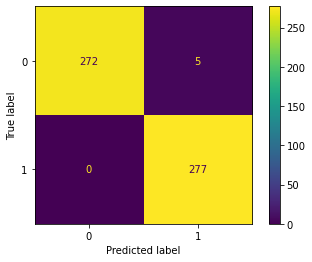

In [28]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test_lda, y_test)

從confusion matrix可以看出來，雖然這個model會有誤判的時候，但卻不會錯過任何"下半旬"開花的可能性，且預測會開花、而真的有開花的機率挺高的，約為98.2%（=277/(277+5)）。

#### 函館
讀進input data，並進行一連串data preprocessing。

In [29]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# read in data for prediction for Hakodate
path = "data_hakodate_pre.csv"
df = pd.read_csv(path, encoding='latin1')

# put data into X & y
data = df.T
X = []
y = []
for i in range(len(data.T)): # for total input data
    # store all data into X & y
    X.append(np.array(data[i][3:24]))
    y.append(data[i][24])

# balance data
y = np.array(y)
X = np.array(X)
X_upsampled, y_upsampled = resample(X[y==1],
                                   y[y==1],
                                   replace=True,
                                   n_samples=X[y==0].shape[0],
                                   random_state=123)
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))

# split into 70% training & 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_bal, 
        y_bal, test_size=0.3, random_state=1, stratify=y_bal)

# standardize Xs
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# feature-extract Xs
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)
print(X_train_lda.shape)
print(X_test_lda.shape)
lda.scalings_

(1292, 1)
(554, 1)


array([[-0.17742807],
       [-0.00894984],
       [ 0.38458295],
       [-0.09998159],
       [-0.08707423],
       [ 3.96302374],
       [-2.96997558],
       [-3.57366288],
       [ 0.15263918],
       [ 1.03428125],
       [ 0.2671861 ],
       [-0.73523271],
       [-0.46944411],
       [ 1.20433658],
       [ 0.11829928],
       [-0.20451166],
       [-0.39577741],
       [ 0.41661218],
       [-0.90885979],
       [-0.01331803],
       [ 0.05556194]])

有了降過維度的input data後，利用Grid Search找合適的參數。

In [30]:
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn import metrics

# train SVM using Grid Search
svm = SVC(random_state=1)
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'C': param_range,
               'kernel':['linear']},
              {'C': param_range,
               'gamma': param_range,
               'kernel': ['rbf']}]
gs = GridSearchCV(estimator=svm,
                 param_grid = param_grid,
                 scoring='f1',
                 refit=True,
                 cv=10,
                 n_jobs=-1)
start=datetime.now()
gs = gs.fit(X_train_lda, y_train)
print('Training time:', datetime.now()-start)
print(gs.best_score_)
print(gs.best_params_)

clf = gs.best_estimator_
y_pred = clf.predict(X_test_lda)
print ("accuracy:",metrics.accuracy_score(y_test, y_pred))
print ("f1 score:",metrics.f1_score(y_test, y_pred) )
print ("f1 score macro:",metrics.f1_score(y_test, y_pred, average='macro') )
print ("f1 score micro:",metrics.f1_score(y_test, y_pred, average='micro') )

Training time: 0:00:21.270842
0.9863385827703619
{'C': 100.0, 'gamma': 1000.0, 'kernel': 'rbf'}
accuracy: 0.9891696750902527
f1 score: 0.9892857142857143
f1 score macro: 0.9891684045881126
f1 score micro: 0.9891696750902527


可以看到與東京和京都的資料相比，函館的準確率要再低一些，約98.9%。

最後畫出consusion matrix。

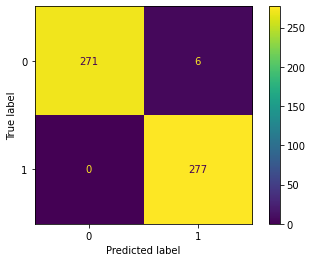

In [31]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test_lda, y_test)

和前述模型相同，雖然這個model也會有誤判的時候，但卻不會錯過任何"下半旬"開花的可能性，且預測會開花、而真的有開花的機率挺高的，約為97.9%（=277/(277+6)）。

### References
* 機器學習講義與筆記
* python 相關教學網頁